In [68]:
from pathlib import Path
import yaml
import pandas as pd
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.model_selection import train_test_split
import joblib 
import numpy as np

# Preprocess the data

In [69]:
data_dir = Path('input/')
with open('hand/config.yaml') as f:
    config = yaml.safe_load(f)

config
output_dir = Path('output/' + config['date_output'] + '/')

df_ravinia = pd.read_excel(data_dir / 'ravinia_data_2024.xlsx')

# Preprocessing
df_ravinia['descrip'] = df_ravinia['descrip'].astype(str)
df_ravinia['descrip'] = df_ravinia['descrip'].replace('nan', '')
df_ravinia = df_ravinia[df_ravinia['descrip'] != '']

In [70]:
df_ravinia.head(10)

,band,date,descrip,genre
0,The Return of The Flock featuring Jerry Goodman,2024-06-07,Columbia and Mercury recording artists The Flo...,jazz
1,James Taylor & His All-Star Band,2024-06-08,"As a recording and touring artist, James Taylo...",rock
2,James Taylor & His All-Star Band,2024-06-09,"As a recording and touring artist, James Taylo...",rock
5,Robert Plant & Alison Krauss,2024-06-12,After closing the 14-year gap between two albu...,blues
6,Kronos Quartet: Five Decades,2024-06-13,One of the most influential chamber groups of ...,classical
7,Hauser,2024-06-14,"Hauser, the superstar cellist whose rise to fa...",classical
8,Michael Franti & Spearhead,2024-06-15,"Michael Franti, the noted American singer-song...",hip hop
9,Trevor Hall,2024-06-15,"Singer-songwriter and guitarist Trevor Hall, w...",folk
13,Trombone Shorty,2024-06-19,"Trombone Shorty, also known as Troy Andrews, i...",jazz
14,Big Boi,2024-06-19,"Rapper, producer, and actor Big Boi, known bes...",rap


In [71]:
df_ravinia.shape

(91, 4)

Only keep the first example of each band to avoid train/test leakage

In [72]:
df_ravinia = df_ravinia.groupby('band').first().reset_index()

# Split into train + test

In [73]:
df_train, df_test = train_test_split(df_ravinia, random_state=42)

Train requires the tokens and document ID

In [74]:
def process_and_tokenize_series(df_pandas, 
                                col_to_process, 
                                tokens_only=True):
    for i, doc in enumerate(df_pandas[col_to_process]):
        tokens = simple_preprocess(doc) # seems to remove stop words
        if tokens_only:
            yield tokens 
        else:
            yield TaggedDocument(tokens, [i])

train = list(process_and_tokenize_series(df_train, col_to_process='descrip', tokens_only=False))
test = list(process_and_tokenize_series(df_test, col_to_process='descrip'))

# Instantiate the model + train

In [75]:
vector_size = 100
min_count = 2
epochs = 1500

model = Doc2Vec(
    vector_size=vector_size, 
    min_count=min_count, 
    epochs=epochs
)

In [76]:
model.build_vocab(train)

In [77]:
model.train(train, total_examples=model.corpus_count, epochs=model.epochs)
filename_model = 'ravinia_model.sav'
joblib.dump(model, output_dir / filename_model)

['output\\2024_03_25\\ravinia_model.sav']

# Test

In [78]:
test_doc_idx = 0
test_doc = test[test_doc_idx]
print(test_doc)
test_doc_vec = model.infer_vector(test_doc)

sims = model.dv.most_similar([test_doc_vec], topn=len(train))

print('most similar: ')
print(train[sims[0][0]].words)

print('least similar:')
print(train[sims[len(train) - 1][0]].words)

['the', 'knights', 'an', 'orchestral', 'collective', 'led', 'by', 'an', 'open', 'minded', 'spirit', 'of', 'camaraderie', 'and', 'collaboration', 'join', 'pianist', 'aaron', 'diehl', 'an', 'artist', 'quietly', 're', 'defining', 'the', 'lines', 'between', 'jazz', 'and', 'classical', 'onstage', 'at', 'the', 'martin', 'theatre', 'the', 'group', 'performs', 'excerpts', 'from', 'jazz', 'titan', 'mary', 'lou', 'williams', 'zodiac', 'suite', 'on', 'the', 'tail', 'of', 'recording', 'this', 'joyous', 'enchanting', 'creation', 'the', 'guardian', 'that', 'publication', 'continued', 'that', 'the', 'moods', 'crammed', 'into', 'each', 'sign', 'three', 'minutes', 'are', 'wonder', 'the', 'playing', 'and', 'on', 'pisces', 'operatic', 'singing', 'inspired', 'triumph', 'the', 'orchestra', 'presents', 'the', 'ravinia', 'premiere', 'of', 'louise', 'farrenc', 'finale', 'allegro', 'from', 'symphony', 'no', 'in', 'minor', 'and', 'concludes', 'the', 'program', 'with', 'beethoven', 'symphony', 'no', 'pastoral']


In [79]:
print(df_test.iloc[test_doc_idx]['genre'])
print(df_train.iloc[sims[0][0]]['genre'])
print(df_train.iloc[len(train) - 1]['genre'])

classical
classical
classical


In [80]:
stirling_doc = simple_preprocess('Lindsey Stirling (born September 21, 1986) is an American violinist, songwriter, and dancer. She presents choreographed violin performances, in live and music videos found on her official YouTube channel, which she created in 2007. Stirling performs a variety of music styles, from classical to pop and rock to electronic dance music. Aside from original work, her discography contains covers of songs by other musicians such as Johann Sebastian Bach, Ludwig van Beethoven, Wolfgang Amadeus Mozart, and Antonio Vivaldi and various soundtracks.')
print(stirling_doc)
stirling_doc_vec = model.infer_vector(stirling_doc)

sims_stirling = model.dv.most_similar([stirling_doc_vec], topn=len(train))

print('most similar: ')
print(train[sims_stirling[0][0]].words)

print('least similar:')
print(train[sims_stirling[len(train) - 1][0]].words)

['lindsey', 'stirling', 'born', 'september', 'is', 'an', 'american', 'violinist', 'songwriter', 'and', 'dancer', 'she', 'presents', 'choreographed', 'violin', 'performances', 'in', 'live', 'and', 'music', 'videos', 'found', 'on', 'her', 'official', 'youtube', 'channel', 'which', 'she', 'created', 'in', 'stirling', 'performs', 'variety', 'of', 'music', 'styles', 'from', 'classical', 'to', 'pop', 'and', 'rock', 'to', 'electronic', 'dance', 'music', 'aside', 'from', 'original', 'work', 'her', 'discography', 'contains', 'covers', 'of', 'songs', 'by', 'other', 'musicians', 'such', 'as', 'johann', 'sebastian', 'bach', 'ludwig', 'van', 'beethoven', 'wolfgang', 'amadeus', 'mozart', 'and', 'antonio', 'vivaldi', 'and', 'various', 'soundtracks']


most similar: 
['faculty', 'members', 'of', 'the', 'ravinia', 'steans', 'music', 'institute', 'piano', 'strings', 'program', 'come', 'together', 'for', 'an', 'afternoon', 'of', 'chamber', 'music', 'with', 'violinist', 'midori', 'taking', 'the', 'stage', 'for', 'her', 'first', 'season', 'as', 'the', 'program', 'artistic', 'director', 'she', 'is', 'joined', 'by', 'violinist', 'mihaela', 'martin', 'violist', 'kim', 'kashkashian', 'cellists', 'frans', 'helmerson', 'and', 'clive', 'greensmith', 'and', 'pianist', 'marc', 'andré', 'hamelin', 'on', 'the', 'program', 'is', 'ludwig', 'van', 'beethoven', 'string', 'trio', 'no', 'timo', 'andres', 'piano', 'trio', 'commissioned', 'by', 'rsmi', 'in', 'carlos', 'simon', 'where', 'two', 'or', 'three', 'are', 'gathered', 'and', 'robert', 'schumann', 'piano', 'quintet', 'in', 'flat', 'major']
least similar:
['appearing', 'in', 'acclaimed', 'broadway', 'productions', 'of', 'the', 'sound', 'of', 'music', 'the', 'book', 'of', 'mormon', 'and', 'parade', 'si

# t-SNE

In [81]:
# Create a t-SNE model for the word vectors -- stored in model[i]
wv_idx = list(model.wv.key_to_index.values())
wv_list = np.array([model[i] for i in wv_idx])
wv_labels = list(model.wv.key_to_index.keys())

counts = {}
for token in model.wv.key_to_index.keys():
    counts[token] = model.wv.get_vecattr(token, 'count')

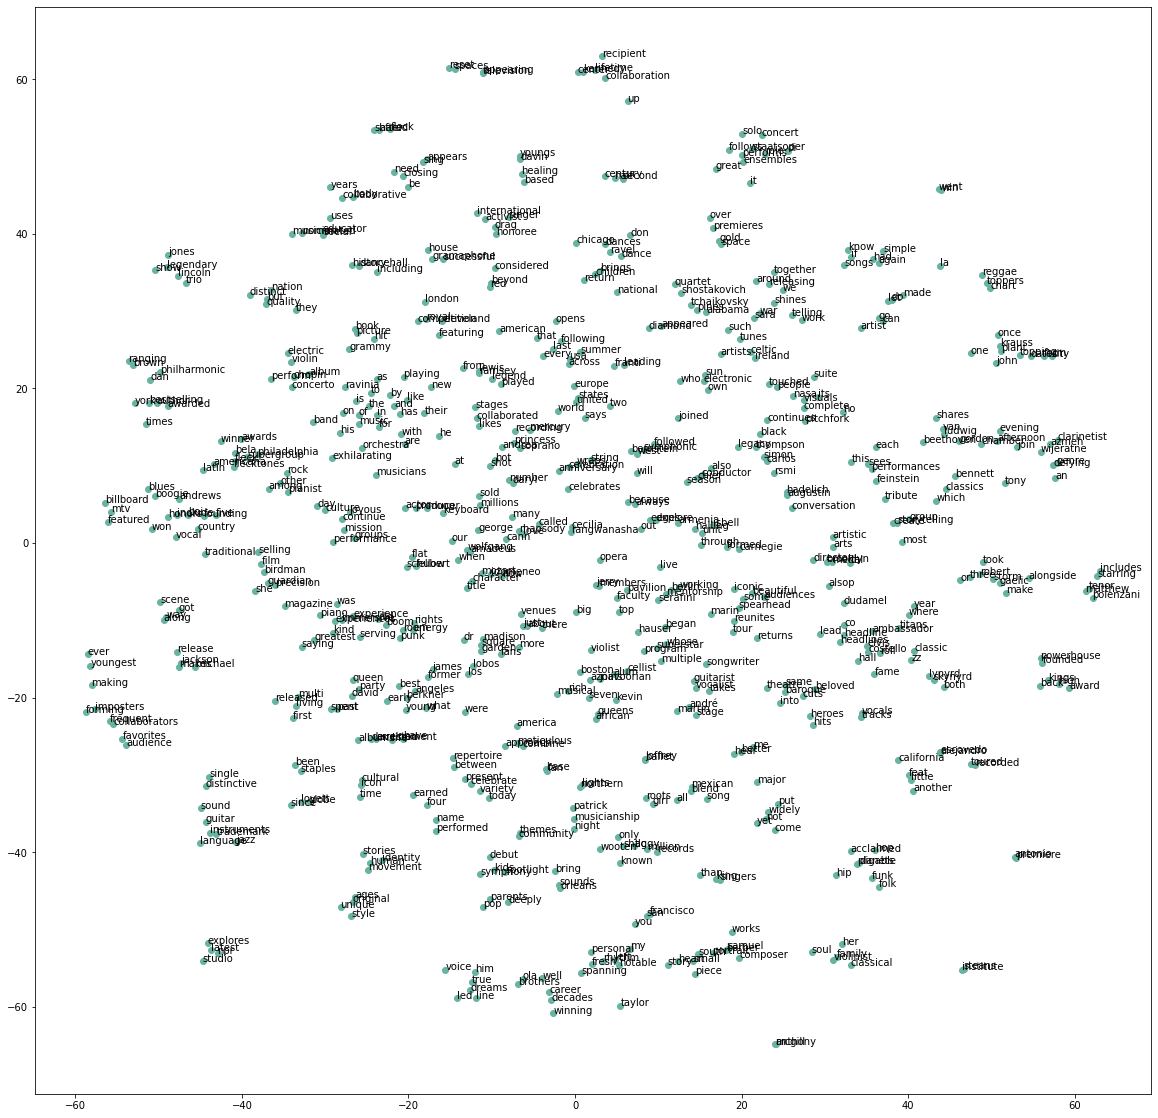

In [84]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne_model = TSNE(perplexity=5, n_components=2)
tsne_values = tsne_model.fit_transform(wv_list)

xs = []
ys = []

for i in range(0, len(tsne_values)):
    xs.append(tsne_values[i][0])
    ys.append(tsne_values[i][1])

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(xs, ys, c='#69b3a2')

for label, x, y in zip(wv_labels, xs, ys):
    ax.annotate(label, xy=(x, y))

fig.savefig(output_dir / 'ravinia_2024_tsne.png')

# Things I learned

* `doc2vec` and `t-SNE`